# SI 370: Homework 4: Malicious and Benign Websites

## <font color='green'>Kelsey Toporski, ktops</font>
### <font color='green'>My responses and explanations are in green below.</font>

This homework assignment uses the dataset  from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

In this assignment, you will perform three tasks, each worth 10 points (specific point allocations are provided for each task).  


First, let's load the data:

In [36]:
# importing everything we need
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [37]:
# reading in the data
data = pd.read_csv('data/malicious_and_benign.csv')

In [38]:
data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [39]:
data.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

## Part 1: k-means clustering

### Perform a K-means clustering of the websites in the dataset (7 points).

### Examine the silhouette scores for different values of K, and report the optimal value of K (3 points).


In [40]:
# drop all of the none values
data2 = data.replace('None', np.nan)
data2 = data2.dropna()

In [41]:
# want to split up the month, day, year, time into different things
data2['updated_year'] = pd.to_datetime(data2['WHOIS_UPDATED_DATE']).apply(lambda x: int(x.year))
data2['updated_month'] = pd.to_datetime(data2['WHOIS_UPDATED_DATE']).apply(lambda x: int(x.month))
data2['updated_day'] = pd.to_datetime(data2['WHOIS_UPDATED_DATE']).apply(lambda x: int(x.day))
# data2['updated_time'] = pd.DatetimeIndex(data2['WHOIS_UPDATED_DATE']).hour
data2 = data2.drop(columns='WHOIS_UPDATED_DATE')

data2['reg_year'] = pd.to_datetime(data2['WHOIS_REGDATE']).apply(lambda x: int(x.year))
data2['reg_month'] = pd.to_datetime(data2['WHOIS_REGDATE']).apply(lambda x: int(x.month))
data2['reg_day'] = pd.to_datetime(data2['WHOIS_REGDATE']).apply(lambda x: int(x.day))
# data2['reg_time'] = pd.DatetimeIndex(data2['WHOIS_REGDATE']).hour
data2 = data2.drop(columns='WHOIS_REGDATE')

data2_wtype = data2.copy()

data2.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,...,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,updated_year,updated_month,updated_day,reg_year,reg_month,reg_day
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,31,22,...,4380,39,8.0,0,2013,12,9,1997,7,10
6,B0_462,18,6,iso-8859-1,Apache/2,345.0,US,CO,12,0,...,1327,14,2.0,0,2016,1,7,2002,7,29
7,B0_1128,19,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,FL,0,0,...,0,0,0.0,0,2017,3,19,1997,3,18
11,B0_1102,20,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,CO,0,0,...,0,0,0.0,0,2016,11,23,2016,11,22
16,M0_97,21,7,iso-8859-1,nginx,686.0,RU,Novosibirskaya obl.,6,0,...,745,8,2.0,1,2016,5,23,2013,5,25


In [42]:
# take out everything else that's not a number
data2 = data2.drop(columns=['URL', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'updated_year', 'updated_month', 'updated_day', 'reg_year', 'reg_month', 'reg_day', 'Type'])
data2.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0
6,18,6,345.0,12,0,3,1189,14,13,8559,1327,14,2.0
7,19,6,324.0,0,0,0,0,0,0,0,0,0,0.0
11,20,6,324.0,0,0,0,0,0,0,0,0,0,0.0
16,21,7,686.0,6,0,2,603,8,9,1580,745,8,2.0


<font color='green'>
We removed all of the non-numerical data, as k-means requires, but we also removed the date data that we just split up. The date data was unimportant to the clustering in this part, and skewed the data, so I decided it was best that it jsut be removed for this part.
</font>

In [43]:
# scaling the data
dcols1 = list(data2.columns)
data2_scaled = pd.DataFrame(scale(data2), columns=dcols1)
data2_scaled.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,-1.550809,-1.163403,-0.447463,0.260262,2.778316,0.004083,0.461302,0.367052,0.294845,-0.007965,0.541786,0.367052,2.280517
1,-1.511786,-1.163403,-0.440290,-0.099991,-0.481028,0.004083,-0.118317,-0.100137,-0.117101,-0.116960,-0.121674,-0.100137,-0.029051
2,-1.472762,-1.163403,-0.441113,-0.327519,-0.481028,-0.861553,-0.381056,-0.361763,-0.340239,-0.208195,-0.410049,-0.361763,-0.798907
3,-1.433739,-1.163403,-0.441113,-0.327519,-0.481028,-0.861553,-0.381056,-0.361763,-0.340239,-0.208195,-0.410049,-0.361763,-0.798907
4,-1.394716,-0.920566,-0.426924,-0.213755,-0.481028,-0.284462,-0.247808,-0.212263,-0.185759,-0.191353,-0.248150,-0.212263,-0.029051


<font color='green'>
Here I scaled the data because the ranges for the different columns were very different, and I didn't want the results to be skewed.
</font>

In [44]:
# looking at silhouette scores
for i in range(3, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data2_scaled)
    labels = kmeans.labels_
    X = data2_scaled.values
    y_km = kmeans.fit_predict(X)
    print("silhouette score when k = " + str(i) + ": " + str(metrics.silhouette_score(data2_scaled,kmeans.labels_)))

silhouette score when k = 3: 0.3570725744386704
silhouette score when k = 4: 0.346081730394139
silhouette score when k = 5: 0.3177300251063504
silhouette score when k = 6: 0.3525487889627143
silhouette score when k = 7: 0.36235279213087124
silhouette score when k = 8: 0.3301148337801108
silhouette score when k = 9: 0.3118758605590926
silhouette score when k = 10: 0.32305129014704903
silhouette score when k = 11: 0.32008265142403486
silhouette score when k = 12: 0.32979273772232065
silhouette score when k = 13: 0.33597894490651786
silhouette score when k = 14: 0.25720531510045436


In [50]:
# checking out the grouping of the clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(data2_scaled)
kmeans.labels_

# there's only one 1: an outlier!!!

array([5, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3,
       3, 3, 2, 2, 6, 3, 3, 3, 3, 3, 3, 2, 5, 2, 2, 3, 3, 3, 2, 3, 3, 2,
       2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 4, 2, 3, 3, 3, 2, 2, 3, 3, 2,
       3, 3, 3, 3, 5, 2, 2, 2, 2, 5, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 2, 2, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 2, 2,
       3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3,
       3, 3, 3, 3, 2, 2, 6, 3, 2, 5, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 6, 2, 5, 5, 3, 2, 2, 2, 3, 3, 3, 5, 2, 3, 3, 5, 3, 2, 2, 2,
       2, 2, 6, 2, 6, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 2, 2, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3,

In [51]:
# we saw above that there is only one 1, so we want to remove it because it's an outlier
data2_noout = pd.concat([pd.DataFrame(kmeans.labels_).reset_index(),data2_scaled.reset_index()],axis=1).drop('index',axis=1)
data2_noout = data2_noout[data2_noout[0] != 1]

In [52]:
# reevaluating the silhouette score without the outlier
for i in range(3, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data2_noout)
    labels = kmeans.labels_
    X = data2_noout.values
    y_km = kmeans.fit_predict(X)
    print("silhouette score when k = " + str(i) + ": " + str(metrics.silhouette_score(data2_noout,kmeans.labels_)))

silhouette score when k = 3: 0.4071415736657133
silhouette score when k = 4: 0.41338269809884715
silhouette score when k = 5: 0.42524284294040016
silhouette score when k = 6: 0.4379974426452286
silhouette score when k = 7: 0.4319173588076113
silhouette score when k = 8: 0.3763689518844954
silhouette score when k = 9: 0.2672516276505881
silhouette score when k = 10: 0.2897125567887343
silhouette score when k = 11: 0.26806297605154394
silhouette score when k = 12: 0.26483206536446147
silhouette score when k = 13: 0.3116947445195535
silhouette score when k = 14: 0.27790716246488967


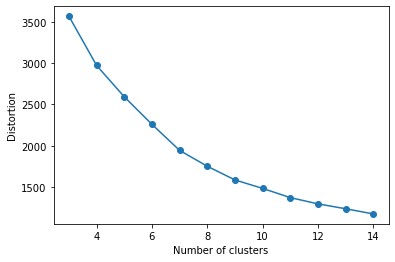

In [53]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(3, 15):
    km = KMeans(n_clusters=i)
    km.fit(data2_scaled)
    distortions.append(km.inertia_)

# plot
plt.plot(range(3, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<font color='green'> 
Based off of this graph and the silhouette scores, 6 is the optimal number of clusters (this is mostly evidenced by k = 6 having hte highest silhouette score). Having 6 clusters as optimal in k-means clustering means that there are 6 groups of similar sites.
</font>

## Part 2: Random forest classification
*NOTE*: Use the ```malicious_and_benign_train.csv``` and ```malicious_and_benign_test.csv``` for your training and testing datasets, respectively.

NOTE: I have created a new notebook called "BetterClassifiers.ipynb" that contains a revision of the code I used in

### Create a random forest classifier (3 points).

### Report the accuracy of your resulting classifier (2 points).

### Report the most important feature (2 points).

### Try tuning the hyperparameters to see if you can improve the accuracy (3 points).

### *BONUS*: The top 5 accuracy scores in the class will receive a 2-point bonus.

In [54]:
# read in testing data
test = pd.read_csv('data/malicious_and_benign_test.csv')
test = test.drop(columns=['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'])
test.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2211,78,15,ISO-8859-1,Varnish,9.0,US,DC,8,6,6,672,8,9,562,672,8,0.0,0
1,B0_854,39,8,utf-8,YouTubeFrontEnd,NaN,US,CA,0,0,0,0,0,0,0,0,0,0.0,0
2,B0_242,43,9,utf-8,Varnish,389.0,US,CA,83,2,3,6008,87,107,147266,6312,87,4.0,0
3,B0_880,52,10,ISO-8859-1,Apache,5443.0,CA,Quebec,0,0,0,0,0,0,0,0,0,0.0,0
4,M4_6,100,20,UTF-8,Apache,NaN,ES,Barcelona,1,0,1,66,1,3,190,66,1,0.0,1


In [55]:
# read in training data
train = pd.read_csv('data/malicious_and_benign_train.csv')
train = train.drop(columns=['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'])
train.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_777,37,8,utf-8,Apache/2.2.29 (Unix) mod_ssl/2.2.29 OpenSSL/1....,6944.0,US,Arizona,0,0,0,0,0,0,0,0,0,0.0,0
1,B0_1123,49,9,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,MI,0,0,0,0,0,0,0,0,0,0.0,0
2,B0_2045,54,12,UTF-8,mw2104.codfw.wmnet,NaN,US,CA,11,7,2,1166,11,7,426,1166,11,0.0,0
3,B0_405,64,11,UTF-8,Server,NaN,US,NV,39,18,14,4631,49,42,12921,5353,49,10.0,0
4,B0_1407,70,12,UTF-8,mw2178.codfw.wmnet,NaN,US,CA,0,0,0,0,0,0,0,0,0,0.0,0


In [56]:
# make it only numerical
train = train[list(train.describe())]
test = test[list(test.describe())]

train = train.dropna()
test = test.dropna()

In [57]:
# we want x to be everything but type, and y to be only type
y_train = train['Type']
y_test = test['Type']

X_train = train.drop(columns='Type')
X_test = test.drop(columns='Type')

In [58]:
X_train.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,37,8,6944.0,0,0,0,0,0,0,0,0,0,0.0
1,49,9,324.0,0,0,0,0,0,0,0,0,0,0.0
6,22,7,4421.0,12,0,2,2259,16,12,5165,2559,16,4.0
8,44,10,360.0,16,3,4,1480,20,23,10665,1776,20,4.0
11,89,12,30193.0,25,13,8,1818,25,7,438,1818,25,0.0


In [59]:
y_train.head()

0     0
1     0
6     0
8     0
11    0
Name: Type, dtype: int64

In [60]:
# create a random forest classifier - based off of the better classifiers notebook
seed = 7

model = RandomForestClassifier(
    n_estimators=100,
    random_state=seed, 
    criterion='entropy',
    max_depth=None, 
    min_samples_split=2)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(y_pred)

# check accuracy
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0]
Accuracy: 94.21%


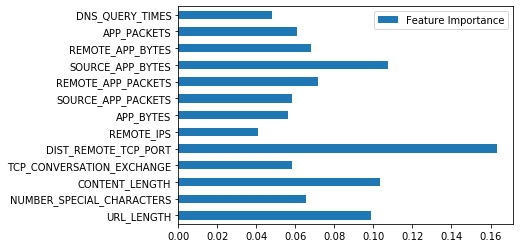

In [61]:
# check feature importance
X = data2

feat_importance = model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=list(X)).plot(kind='barh')

<font color='green'>
Based off of this graph, the feature with the most importance determining if a site is malicious or not is DIST_REMOTE_TCP_PORT. According to the kaggle page, this is the number of ports detected that are different from TCP. When a site is malicious, it can do port sniffing, which is sending out a lot of syn packets to see which ports are open. If a port is open, your network can be hacked into. If a site it malicious, it will have tried to access several differnet ports other than TCP, which is just the networks that the program has established a connection with by doing the 3-way handshake. I am relying heavily on my knowledge of EECS 388 (cyber security) here, so I hope this makes sense. 
</font>

In [62]:
# tuning hyper parameters:
seed = 11 # changed seed to 11, made more accurate

model = RandomForestClassifier(
    n_estimators=100, # tried some different values of this, didn't effect it too much
    random_state=seed, 
    criterion='entropy',
    max_depth=None, 
    min_samples_split=3) # changed to 3, made more accurate

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(y_pred)

# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0]
Accuracy: 96.32%


<font color='green'>
After tuning the parameters, we can see that changing the seed to 11 instead of 7 makes the model more accurate, upping it by around 1.5%. To the best of my knowledge, the seed is what helps start off the random number generator. I'm not sure why this would effect the accuracy if it just helps produce a random number, but after playing around with several values, 11 seems to give me the best result. I also changed the number of min samples split to 3, and it increased the score again by about 1%. min_samples_split gives the amount of samples required to split into another group increasing this a little ensures that there are a decent amount of examples before we go and classify a whole new group. After tuning these hyperparameters, I got an accuracy score of 96.32%.
</font>

## Part 3: Dimension reduction
### Use principal components analysis to reduce the original dataset to fewer dimensions (remember to scale the data) (3 points). Explain your results.

### Describe the first dimension in terms of the original variables (2 points).

### Report the optimal number of reduced dimensions based on a scree plot (2 points).  Explain and justify your choice.

### Use t-SNE to create a visualization of the malicious and benign websites in 2-D space (3 points).  Tune your perplexity and iterations to get the "best" results.

NOTE: Read more about tuning t-SNE here: https://distill.pub/2016/misread-tsne/

### Bonus (max 2 points): Use Bokeh to create an interactive visualization (e.g. using hover) to allow users to explore your t-SNE results.  Report an interesting finding about the data from your visualization.

In [63]:
# make a copy of the original data with only nums
data3 = data2.copy()
data3.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0
6,18,6,345.0,12,0,3,1189,14,13,8559,1327,14,2.0
7,19,6,324.0,0,0,0,0,0,0,0,0,0,0.0
11,20,6,324.0,0,0,0,0,0,0,0,0,0,0.0
16,21,7,686.0,6,0,2,603,8,9,1580,745,8,2.0


In [64]:
# scaling the data before PCA
dcols = list(data3.columns)
data3_scaled = pd.DataFrame(scale(data3), columns=dcols)
data3_scaled.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,-1.550809,-1.163403,-0.447463,0.260262,2.778316,0.004083,0.461302,0.367052,0.294845,-0.007965,0.541786,0.367052,2.280517
1,-1.511786,-1.163403,-0.440290,-0.099991,-0.481028,0.004083,-0.118317,-0.100137,-0.117101,-0.116960,-0.121674,-0.100137,-0.029051
2,-1.472762,-1.163403,-0.441113,-0.327519,-0.481028,-0.861553,-0.381056,-0.361763,-0.340239,-0.208195,-0.410049,-0.361763,-0.798907
3,-1.433739,-1.163403,-0.441113,-0.327519,-0.481028,-0.861553,-0.381056,-0.361763,-0.340239,-0.208195,-0.410049,-0.361763,-0.798907
4,-1.394716,-0.920566,-0.426924,-0.213755,-0.481028,-0.284462,-0.247808,-0.212263,-0.185759,-0.191353,-0.248150,-0.212263,-0.029051


In [71]:
# implementing PCA
pca = PCA(n_components=7).fit(data3_scaled)
pca_samples = pca.transform(data3_scaled)

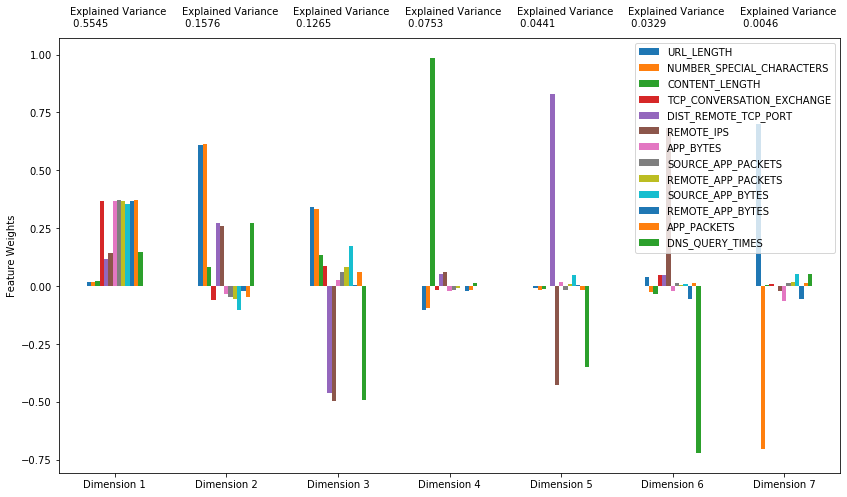

In [72]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_res = pca_results(data3_scaled, pca)

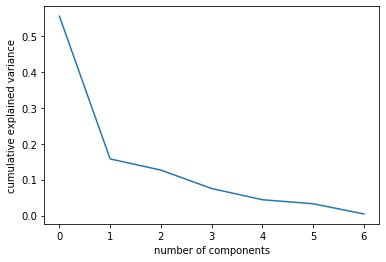

In [73]:
#Explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [74]:
pca_res.cumsum()

,Explained Variance,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
Dimension 1,0.5545,0.0171,0.0182,0.0229,0.3681,0.1162,0.1416,0.3692,0.3700,0.3679,0.3551,0.3696,0.3700,0.1470
Dimension 2,0.7121,0.6279,0.6339,0.1052,0.3088,0.3908,0.4033,0.3366,0.3248,0.3106,0.2516,0.3497,0.3248,0.4191
Dimension 3,0.8386,0.9705,0.9664,0.2380,0.3958,-0.0695,-0.0931,0.3621,0.3866,0.3951,0.4253,0.3533,0.3866,-0.0738
Dimension 4,0.9139,0.8697,0.8731,1.2243,0.3795,-0.0180,-0.0317,0.3398,0.3713,0.3856,0.4281,0.3319,0.3713,-0.0598
Dimension 5,0.9580,0.8628,0.8555,1.2101,0.3792,0.8129,-0.4601,0.3594,0.3540,0.3936,0.4783,0.3348,0.3540,-0.4091
Dimension 6,0.9909,0.9029,0.8307,1.1763,0.4276,0.8631,0.2248,0.3365,0.3668,0.3966,0.4887,0.2807,0.3668,-1.1294
Dimension 7,0.9955,1.6036,0.1270,1.1796,0.4382,0.8656,0.2057,0.2746,0.3802,0.4125,0.5422,0.2253,0.3802,-1.0761


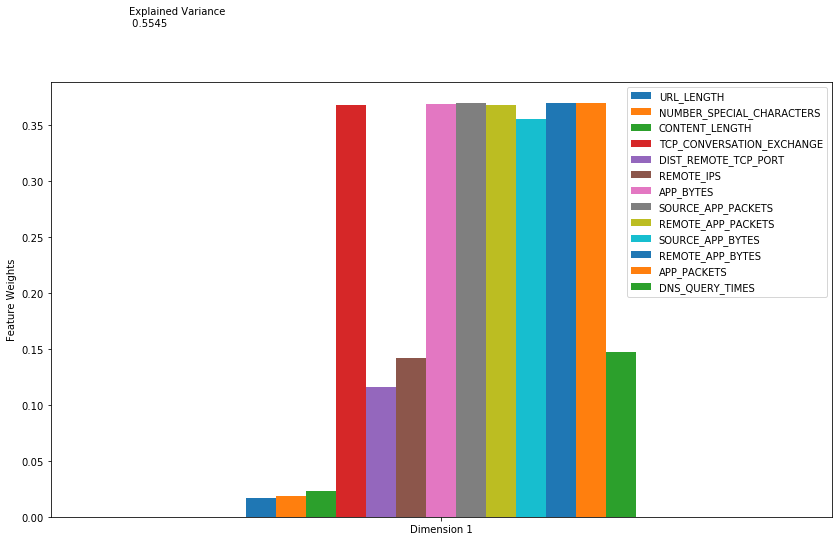

In [75]:
pca = PCA(n_components=1).fit(data3_scaled)
pca_samples = pca.transform(data3_scaled)
pca_res = pca_results(data3_scaled, pca)

<font color='green'>
In the first dimension, TCP_CONVERSION_EXCHANGE, APP_BYTES, SOURCE_APP_PACKETS, REMOTE_APP_PACKETS, SOURCE_APP_BYTES, REMOTE_APP_BYTES, and APP_PACKETS are all higher and therefore stronger in this dimension, meaning they are more positively correlated than the remaining factors, which makes sense because most of them about about APP. Based on the cumsum() function, dimension 1 explains 55% of the variance which is quite high. Based on the scree plot, the optimal number of components is 1, because there is a sharp elbow at 1. Cutting the dimensions down to 1 makes sense, as more than half of the variance is explained by the first dimension.
</font>

In [76]:
# t-SNE with default perplexity and n_iter
tsne = TSNE(n_components=2, random_state=0)
X = data3_scaled
X_2d = tsne.fit_transform(X)
ty = data2_wtype['Type'].values

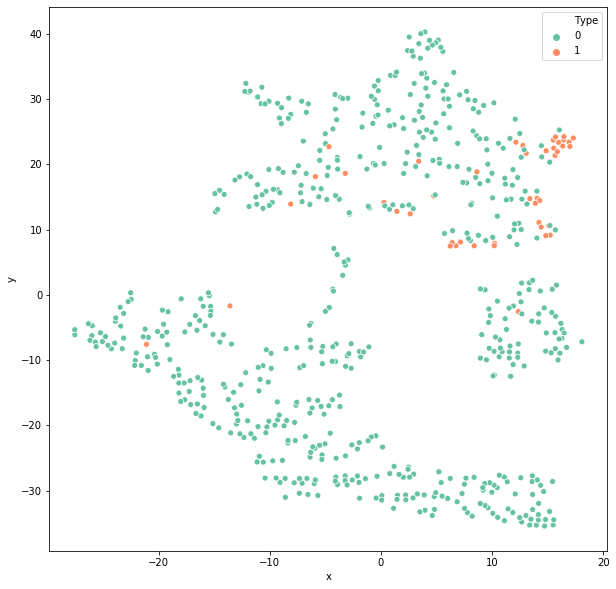

In [77]:
# change to dataframe so that we can run it on seaborn
out = []
for i,(x,y) in enumerate(X_2d):
    out.append((ty[i],x,y))
df = pd.DataFrame(out,columns=['Type','x','y'])
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='x',y='y',hue='Type',legend='full',palette='Set2')
plt.show()

In [78]:
# t-SNE after messing with perplexity and n_iter
perplexity = 20
n_iter = 500

tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=n_iter)
X = data3_scaled
X_2d = tsne.fit_transform(X)
ty = data2_wtype['Type'].values

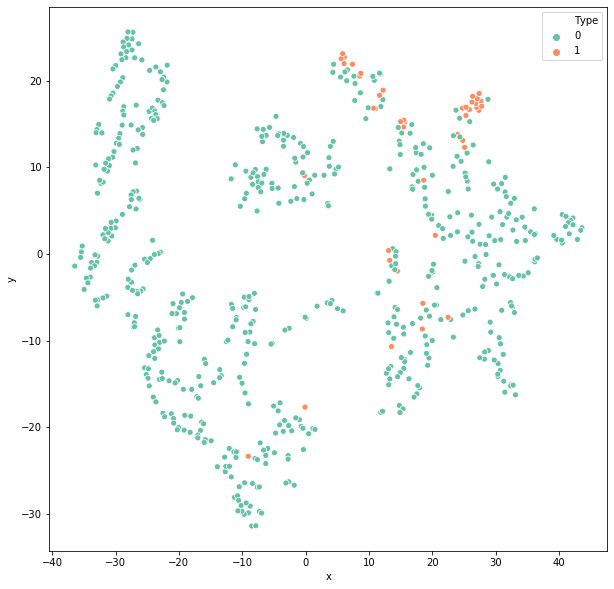

In [79]:
# change to dataframe so that we can run it on seaborn
out = []
for i,(x,y) in enumerate(X_2d):
    out.append((ty[i],x,y))
df = pd.DataFrame(out,columns=['Type','x','y'])
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='x',y='y',hue='Type',legend='full',palette='Set2')
plt.show()

<font color='green'>
After setting the perplexity to 20 and the iterations to 500, we can see the plot is better. The malicious sites (1, orange) are mostly plotted in the same general area and are closer together. This is evidence of better clustering. The non-malicious websites (0, green) are spred out throughout the graph, but are still somewhat clustered together into little sub groups. This points to non-malicious sites having similar features to each other that are causing them to be clustered together.
</font>